<a href="https://colab.research.google.com/github/gilad-altshuler/Three_Body_RNN/blob/main/notebooks/3_Teacher_Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import sys, os
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Colab. Cloning repo...")
    !git clone https://github.com/gilad-altshuler/Beyond_Linear_Summation-Three_Body_RNNs.git
    %cd Beyond_Linear_Summation-Three_Body_RNNs
    ROOT = Path(".").resolve()

    # Load Arial font
    !wget -O Arial.ttf "https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf"

else:
    print("Not running in Colab.")
    ROOT = Path(__file__).resolve().parent.parent
    sys.path.append(str(ROOT))

Running in Colab. Cloning repo...
Cloning into 'Beyond_Linear_Summation-Three_Body_RNNs'...
remote: Enumerating objects: 757, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 757 (delta 100), reused 140 (delta 60), pack-reused 550 (from 2)
Receiving objects: 100% (757/757), 366.58 MiB | 43.60 MiB/s, done.
Resolving deltas: 100% (367/367), done.
/content/Beyond_Linear_Summation-Three_Body_RNNs
--2025-08-05 19:41:32--  https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matomo-org/travis-scripts/master/fonts/Arial.ttf [following]
--2025-08-05 19:41:32--  https://raw.githubusercontent.com/matomo-org/travis-scripts/master/fonts/Arial.ttf
Resolving raw.githubusercontent.com (raw.githubusercon

In [2]:
import torch
import random
from torch import nn
import numpy as np
import copy
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
%matplotlib inline
if IN_COLAB:
  fm.fontManager.addfont('Arial.ttf')
  arial_fp = fm.FontProperties(fname='Arial.ttf')
  plt.rcParams['font.family'] = arial_fp.get_name()
else:
  plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 10
import seaborn as sns

import utils
from tasks import K_Bit_Flipflop_task, sin_task
from Models import *

In [3]:
DATA_DIR = ROOT / "data" / "teacher_student"
FIG_DIR = ROOT / "notebooks" / "figures"

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
SEED = 3150
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#Teacher-Student inference

##Evaluation - Table 1 preperation

In [6]:
from itertools import product
import pickle
import pandas as pd

with open(DATA_DIR / "task_stats.pkl", "rb") as f:
    task_stats = pickle.load(f)
s_ranks = 6
tasks = ["K_Bit_Flipflop_task/1",
         "K_Bit_Flipflop_task/2",
         "K_Bit_Flipflop_task/3",
         "sin_task"]
models = ["rnn","tbrnn"]
task_tab = ["K=1","K=2","K=3","sin"]
stats_tab = ["Rank","R2","Rank (any run)","R2 (any run)"]

columns = pd.MultiIndex.from_tuples(list(product(models, task_tab)))
index = pd.MultiIndex.from_tuples(list(product(models,stats_tab)), names=['Student', 'Metric'])
data = []
r2_threshold = 0.9

for t,task in columns:
    col_data = []
    r2s = task_stats[dict(zip(task_tab,tasks))[task]]['r2s']
    for s in models:

        ## Check if median run can reach the desired R2
        median_student = np.median(np.mean(r2s[t][s],axis=-1),axis=-1)
        if (median_student > r2_threshold).any():
            min_rank = (median_student > r2_threshold).argmax().item() + 1
            r2 = median_student[min_rank-1]
            r2 = f"{r2:.3f}"
        else:
            min_rank = f">{s_ranks}"
            r2 = median_student.max()
            if r2<0:
              r2 = "<0"
            else:
              r2 = f"{r2:.3f}"

        ## Now, check if some run (not the median) can reach the desired R2
        some_student = np.max(np.mean(r2s[t][s],axis=-1),axis=-1)
        if (some_student > r2_threshold).any():
            some_min_rank = (some_student > r2_threshold).argmax().item() + 1
            some_r2 = some_student[some_min_rank-1]
            some_r2 = f"{some_r2:.3f}"
        else:
            some_min_rank = f">{s_ranks}"
            some_r2 = some_student.max()
            if some_r2<0:
              some_r2 = "<0"
            else:
              some_r2 = f"{some_r2:.3f}"

        col_data.append(str(min_rank))
        col_data.append(r2)
        col_data.append(str(some_min_rank))
        col_data.append(some_r2)

    data.append(col_data)

df = pd.DataFrame([list(row) for row in zip(*data)], index=index, columns=columns)

df

rnn                       tbrnn                     
                          K=1    K=2    K=3    sin    K=1    K=2    K=3    sin
Student Metric                                                                
rnn     Rank                1      2      3      2     >6     >6     >6     >6
        R2              0.997  0.997  0.997  0.989     <0     <0     <0  0.576
        Rank (any run)      1      2      3      2     >6     >6     >6      6
        R2 (any run)    0.999  0.999  0.998  0.998     <0  0.139     <0  0.916
tbrnn   Rank               >6     >6      4     >6      1      2      3      2
        R2              0.729  0.861  0.909     <0  0.994  0.946  0.954  0.903
        Rank (any run)      2      3      4      4      1      2      3      2
        R2 (any run)    0.937  0.944  0.987  0.922  0.999  0.995  0.998  0.985

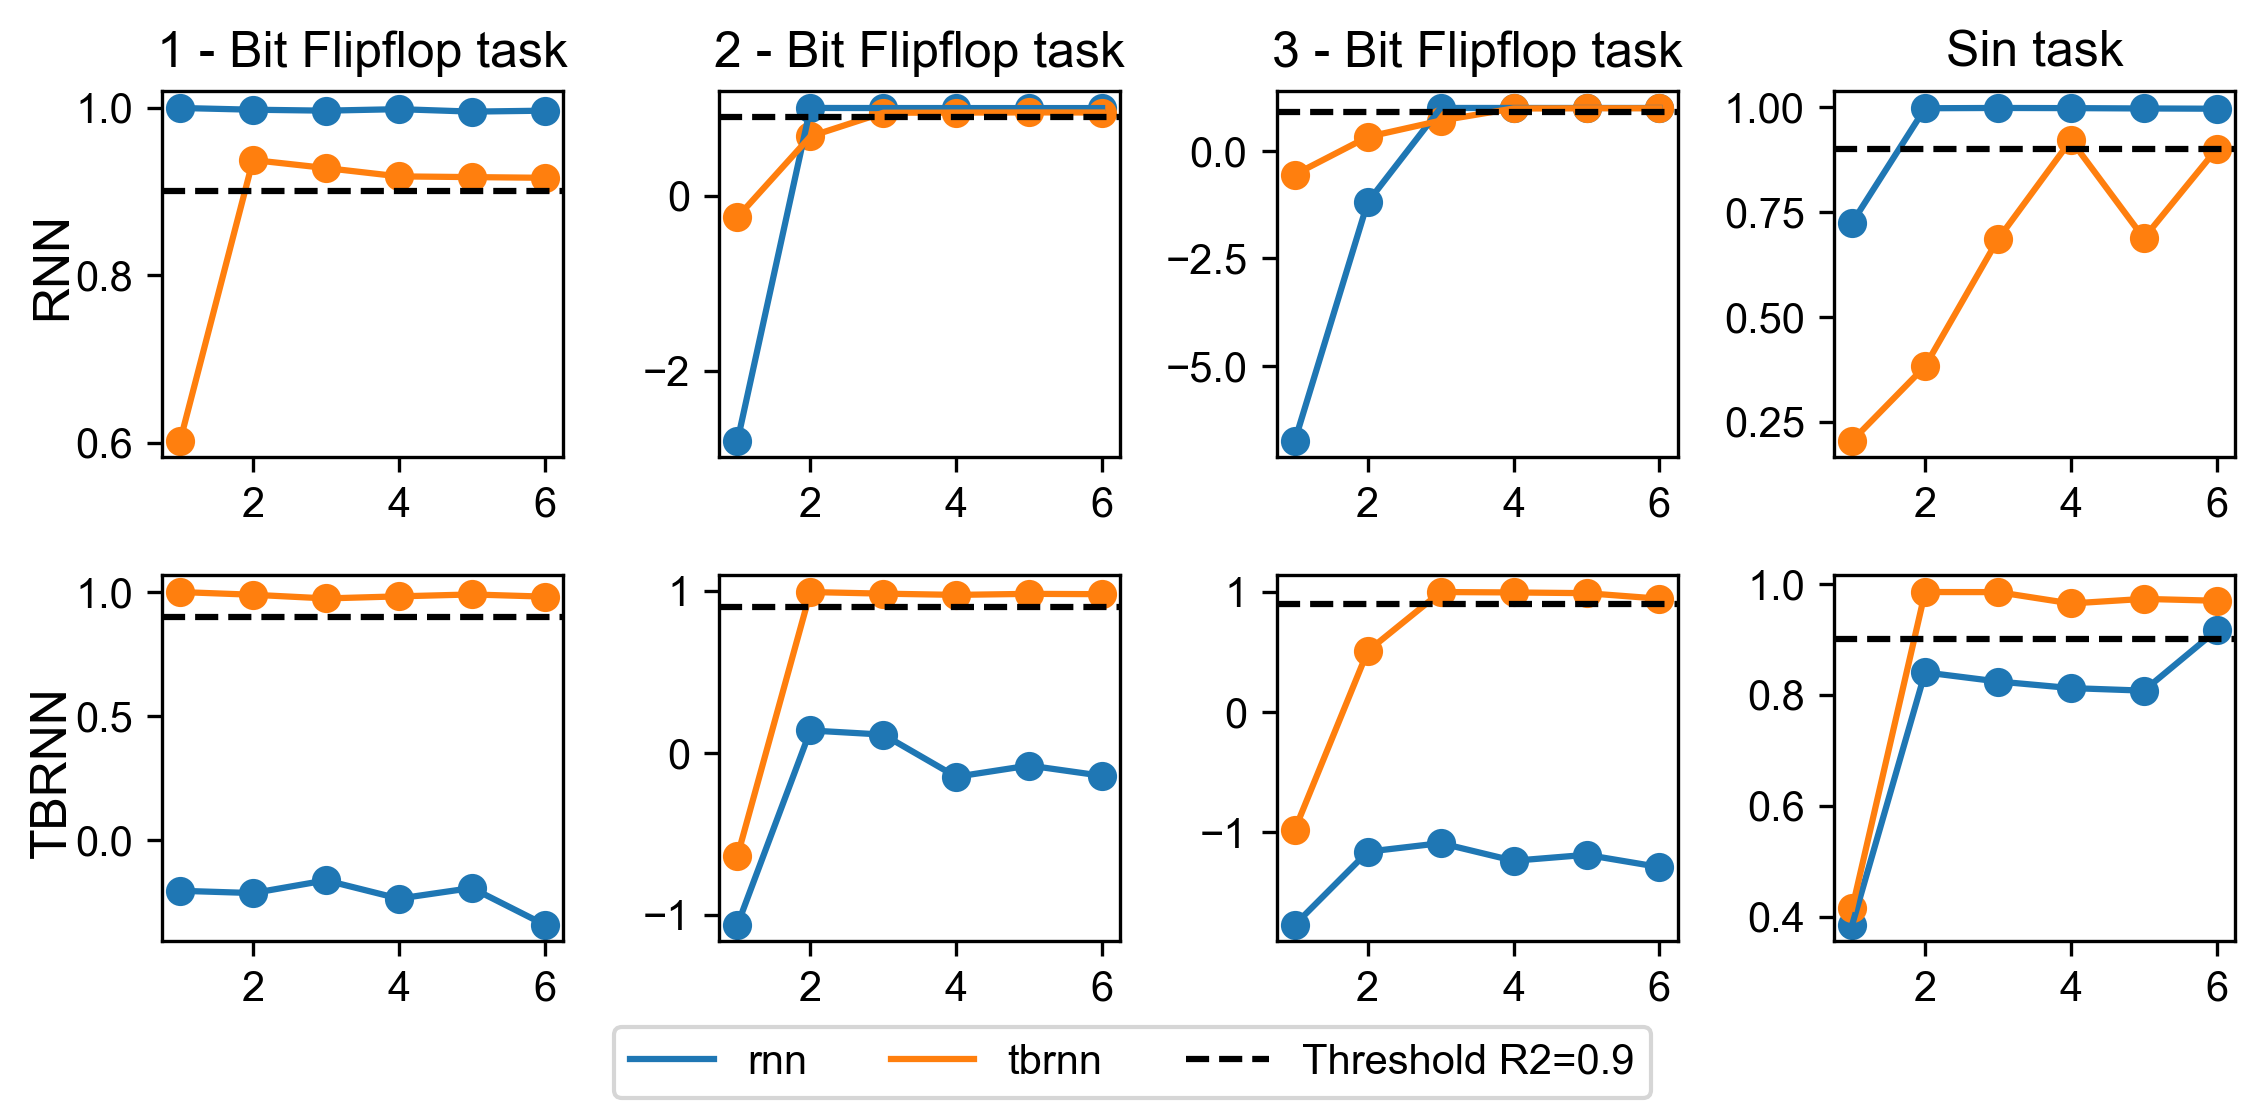

In [7]:
fig = plt.figure(figsize=(7.5,3.75),dpi=300)
ax = fig.subplots(2, 4)
for col,(task_name,stats) in enumerate(task_stats.items()):
  for row,(t_name,stat) in enumerate(stats['r2s'].items()):
    for student in models:
        ax[row][col].plot(range(1,s_ranks+1),np.max(np.mean(stat[student],axis=-1),axis=-1),label=student.lower())
        ax[row][col].scatter(range(1,s_ranks+1),np.max(np.mean(stat[student],axis=-1),axis=-1))
    ax[row][col].axhline(y=0.9, linestyle="--", color="k",label="Threshold R2=0.9")
    if row==0:
      name,K = task_name.split("/")[0],task_name.split("/")[-1]
      name=name.replace("K",K+" -")
      name=name.replace("_"," ")
      name=name.replace("sin","Sin")
      ax[row][col].set_title(name, fontsize=12)
    if col==0:
      fig.text(0.0, 0.75 - row*0.45, t_name.upper(), va='center', rotation='vertical', fontsize=12)

# Add common legend at bottom center
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 1])